# Lab1 Intro
In the retail industry, understanding the Voice of the Customer (VOC) is crucial for gaining insights into customer preferences and pain points. By analyzing and categorizing customer feedback, retailers can improve their products, services, and overall customer experience.

This hands-on workshop guides participants through the process of classifying Voice of Customer (VOC) data using Amazon Foundation Model on Amazon Bedrock.
You will be provided with sample data and will be tasked with classifying customer feedback into categories and generating a summary analysis report.

- First, you will learn how to use Prompt Engineering to classify customer feedback.
- Then, you will explore the concept of embedding techniques and use them to classify customer feedback by semantic comparison.
- After that, you will be provided with additional example data. You will explore the concept of retrieval augmented generation (RAG) and use it to enhance the classification process by dynamically retrieving relevant few-shot examples.
- At the end of the workshop, you will be able to generate a comprehensive analysis report that provides insights into the VOC data and helps retailers improve their products and services.

### A task of developing a VoC Classifier has been assigned to you:
You will be provided with a sample dataset in "data/comments.csv", each record represents a customer comment and its corresponding groundtruth category. You need to write prompt to perform the classification task using the Amazon Foundation Model, and then compare the prediction result with the groundtruth and calculate the accuracy.

### Your objectives are:

- Classify each customer feedback comment into 35+ categories
- Provide the reasoning behind each classification
- Summarize each customer comment in a brief description



## 1. Install dependencies
- If you experince "ERROR: pip's dependency resolver does not currently...", please just ignore it

In [ ]:
!pip install --upgrade pip
!pip install -q langchain==0.2.16 langchain_aws==0.1.17 pandas==2.2.2 openpyxl==3.1.5 termcolor==2.4.0 python-dotenv==1.0.1

## 2. Initialize Bedrock model using LangChain
- First let's see what Amazon Foundation LLMs (Large Language Models) we have in Amazon Bedrock 

In [ ]:
import boto3
import json
import copy
import pandas as pd
from termcolor import colored
# create clients of bedrock
bedrock = boto3.client(service_name='bedrock')
bedrock_runtime = boto3.client(service_name='bedrock-runtime') 
pd.set_option('display.max_rows', None)
results = []

available_models = bedrock.list_foundation_models()
for model in available_models['modelSummaries']:
    if 'Amazon' in model['providerName'] and 'TEXT' in model['outputModalities']: 
        results.append({
            'Model Name': model['modelName'],
            'Model ID': model['modelId'],  # Add Model ID column
            'Provider': model['providerName'],
            'Input Modalities': ', '.join(model['inputModalities']),
            'Output Modalities': ', '.join(model['outputModalities']),
            'Streaming': model.get('responseStreamingSupported', 'N/A'),
            'Status': model['modelLifecycle']['status']
        })

df = pd.DataFrame(results)
display(df)

pd.reset_option('display.max_rows')

We employ the Langchain SDK to configure and initiate a test interaction with the Amazon Foundation Model.
- Import [Langchain](https://www.langchain.com/) SDK to build the application
- Initialize a ChatBedrock object with Amzon Foundation model, the model id is <span style="color: blue;">"amazon.nova-pro-v1:0"</span>

#### Customzie a LangChain ChatModel Class
- As the time of this event, LangChain has not supported the latest Amazon Foundation Model yet, we will customize a LangChain Chat Model Class, so that the latest model can be integrated with the chain prompting in LangChain.

In [ ]:
import boto3
import json
from botocore.exceptions import ClientError
import dotenv
import os
dotenv.load_dotenv()

from typing import Any, AsyncIterator, Dict, Iterator, List, Optional

from langchain_core.callbacks import (
    AsyncCallbackManagerForLLMRun,
    CallbackManagerForLLMRun,
)
from langchain_core.language_models import BaseChatModel, SimpleChatModel
from langchain_core.messages import AIMessageChunk, BaseMessage, HumanMessage,AIMessage,SystemMessage
from langchain_core.outputs import ChatGeneration, ChatGenerationChunk, ChatResult
from langchain_core.runnables import run_in_executor
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_core.output_parsers import StrOutputParser,XMLOutputParser
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder,HumanMessagePromptTemplate


class ChatModelNova(BaseChatModel):

    model_name: str
    br_runtime : Any = None
    ak: str = None
    sk: str = None
    region:str = None

    def _generate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:

        if not self.br_runtime:
            if self.ak and self.sk:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime',
                                               region_name = self.region,
                                              aws_access_key_id = self.ak,
                                               aws_secret_access_key = self.sk
                                              )
            else:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime')
            
        
        new_messages = []
        system_message = ''
        for msg in messages:
            if isinstance(msg,SystemMessage):
                system_message = msg.content
            elif isinstance(msg,HumanMessage):
                new_messages.append({
                        "role": "user",
                        "content": [ {"text": msg.content}]
                    })
            elif isinstance(msg,AIMessage):
                new_messages.append({
                        "role": "assistant",
                        "content": [ {"text": msg.content}]
                    })

        
        temperature = kwargs.get('temperature',0.1)
        maxTokens = kwargs.get('max_tokens',3000)

        #Base inference parameters to use.
        inference_config = {"temperature": temperature,"maxTokens":maxTokens}


        # Send the message.
        response = self.br_runtime.converse(
            modelId=self.model_name,
            messages=new_messages,
            system=[{"text" : system_message}] if system_message else [],
            inferenceConfig=inference_config
        )
        output_message = response['output']['message']

        message = AIMessage(
            content=output_message['content'][0]['text'],
            additional_kwargs={},  # Used to add additional payload (e.g., function calling request)
            response_metadata={  # Use for response metadata
                **response['usage']
            },
        )
        generation = ChatGeneration(message=message)
        return ChatResult(generations=[generation])


    def _stream(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> Iterator[ChatGenerationChunk]:
        if not self.br_runtime:
            if self.ak and self.sk:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime',
                                               region_name = self.region,
                                              aws_access_key_id = self.ak,
                                               aws_secret_access_key = self.sk
                                              )

            else:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime')
            
        
        new_messages = []
        system_message = ''
        for msg in messages:
            if isinstance(msg,SystemMessage):
                system_message = msg.content
            elif isinstance(msg,HumanMessage):
                new_messages.append({
                        "role": "user",
                        "content": [ {"text": msg.content}]
                    })
            elif isinstance(msg,AIMessage):
                new_messages.append({
                        "role": "assistant",
                        "content": [ {"text": msg.content}]
                    })

        
        temperature = kwargs.get('temperature',0.1)
        maxTokens = kwargs.get('max_tokens',3000)

        #Base inference parameters to use.
        inference_config = {"temperature": temperature,"maxTokens":maxTokens}

        # Send the message.
        streaming_response = self.br_runtime.converse_stream(
            modelId=self.model_name,
            messages=new_messages,
            system=[{"text" : system_message}] if system_message else [],
            inferenceConfig=inference_config
        )
        # Extract and print the streamed response text in real-time.
        for event in streaming_response["stream"]:
            if "contentBlockDelta" in event:
                text = event["contentBlockDelta"]["delta"]["text"]
                # print(text, end="")
                chunk = ChatGenerationChunk(message=AIMessageChunk(content=[{"type":"text","text":text}]))

                if run_manager:
                    # This is optional in newer versions of LangChain
                    # The on_llm_new_token will be called automatically
                    run_manager.on_llm_new_token(text, chunk=chunk)

                yield chunk
            if 'metadata' in event:
                metadata = event['metadata']
                # Let's add some other information (e.g., response metadata)
                chunk = ChatGenerationChunk(
                    message=AIMessageChunk(content="", response_metadata={**metadata})
                )
                if run_manager:

                    run_manager.on_llm_new_token('', chunk=chunk)
                yield chunk

    @property
    def _llm_type(self) -> str:
        """Get the type of language model used by this chat model."""
        return "echoing-chat-model-advanced"

    @property
    def _identifying_params(self) -> Dict[str, Any]:
        """Return a dictionary of identifying parameters.

        This information is used by the LangChain callback system, which
        is used for tracing purposes make it possible to monitor LLMs.
        """
        return {
            "model_name": self.model_name,
        }

llm = ChatModelNova(model_name="amazon.nova-pro-v1:0" )


Now, we'll conduct a test run with the Amazon Foundation Model, tasking it to perform a language translation.

In [ ]:
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
llm.invoke(messages)

## 3. Preparing the Dataset to be classified. 
In this section, we will examine the provided Voice of Customers dataset, explore its contents, and identify all the groundtruth categories it includes.
- The data (Voice of Customers) is subject to experiment usage only

### Load the customer review data

- Load the examples data


From the displayed dataset, we can observe that it consists of two columns: 'comment' and 'groundtruth'. The 'comment' column contains collected customer feedback, while the 'groundtruth' column specifies the categories to which each comment belongs.

In [ ]:
comments_filepath = "data/comments.csv"
comments = pd.read_csv(comments_filepath)
display(comments)

- List categories values

The printed output displays all the categories contained within this dataset.

In [ ]:
category_definition = "data/categories.csv"
categories = pd.read_csv(category_definition)
display(categories['mappings'].values)

## 4. Define system prompt and user prompt template

Below, we have outlined templates for both the system prompt and the user prompt. We will use it to guide the Amazon Foundataion model to perform the classification tasks.

Examing the template, there are a few elements that make this prompt efffective for guiding the model in classifying customer feedback accurately. For both prompt, they clearly defines the role of the model as a professional customer feedback analyst and includes detailed, step-by-step instructions on how the classification should be conducted, the format of the output, the tone to be maintained, and specific guidance on handling ambiguous cases.

In [ ]:
system = """You are a professional  customer feedback analyst. Your daily task is to categorize user feedback.
You will be given an input in the form of a JSON array. Each object in the array contains a comment ID and a 'c' field representing the user's comment content.
Your role is to analyze these comments and categorize them appropriately.
Please note:
1. Only output valid XML format data.
2. Do not include any explanations or additional text outside the XML structure.
3. Ensure your categorization is accurate and consistent.
4. If you encounter any ambiguous cases, use your best judgment based on the context provided.
5. Maintain a professional and neutral tone in your categorizations.
"""

user = """
Please categorize user comments according to the following category tags library:
<categories>
{tags}
</categories>

Please follow these instructions for categorization:
<instruction>
1. Categorize each comment using the tags above. If no tags apply, output "Others".
2. Summarize the comment content in no more than 50 words. Replace any double quotation marks with single quotation marks.
</instruction>

Below are the customer comments records to be categorized. The input is an array, where each element has an 'id' field representing the complaint ID and a 'c' field summarizing the complaint content.
<comments>
{input}
</comments>

For each record, summarize the comment, categorize according to the category explainations, and return the  ID, summary , reasons for tag matches, and category.

Output format example:
<output>
  <item>
    <id>xxx</id>
    <summary>xxx</summary>
    <reason>xxx</reason>
    <category>xxx</category>
  </item>
</output>

Skip the preamble and output only valid XML format data. Remember:
- Avoid double quotation marks within quotation marks. Use single quotation marks instead.
- Replace any double quotation marks in the content with single quotation marks.
"""

## 5. Define LangChain prompting chain

- Create a langchain chat template
  
We use the prompt templated provided above to create a Langchain chat template, which will be used later for the chat model. The categories contained within the dataset are passed into the template as variables.
Then, using the prompt and Amazon foundation model we defined earlier, we construct a Langchain prompting chain to carry out the classification task.

In [ ]:
prompt = ChatPromptTemplate([
    ('system',system),
    ('user',user),
    ],
    partial_variables={'tags':categories['mappings'].values}
)
chain = prompt | llm | XMLOutputParser()

- convert the comments to data array

In this step, we will transform the 'comment' column of the dataset into a structured data array. Each element of this array will include both an index and the corresponding comment content. This formatted data will then be used as input for the Amazon foundation model to classify.

In [ ]:
sample_data = [str({"id":'s_'+str(i),"comment":x[0]}) for i,x in enumerate(comments.values)]
print("\n".join(sample_data[:3]))

### We will run classfication in batches (20 records per batch)
* This cell will take around 2 mins to complete
* <span style="color: red;">Hint!</span> Due to the uncertainly of LLM generation, the JSON output might fail occasionally, if you happen to experience error such as `KeyError: 'output'`, please re-run the cell again

In [ ]:
%%time

import math,json,time
batch_size = 20
batch = math.ceil(comments.shape[0]/batch_size)
i = 0
resps = []
for i in range(batch):
    print(colored(f"****[{i}]*****\n","blue"))
    data = sample_data[i*batch_size:(i+1)*batch_size]
    resp = chain.invoke(data)
    print(colored(f"****response*****\n{resp}","green"))
    for item in resp['output']:
        row={}
        for it in item['item']:
            row[list(it.keys())[0]]=list(it.values())[0]
        resps.append(row)
    # time.sleep(10)

- covert the data array to pandas dataframe

We transform the data array, which now contains the output generated by the LLM, into a dataframe for further analysis and review.

In [ ]:
prediction_df = pd.DataFrame(resps).rename(columns={"category":"predict_label"}).drop_duplicates(['id']).reset_index(drop='index')
# convert the label value to lowercase
prediction_df['predict_label'] = prediction_df['predict_label'].apply(lambda x: x.strip().lower().replace("'",""))
prediction_df

### Merge the prediction result to ground truth dataframe

- copy comments to ground_truth dataframe
- merge the date prediction to the groudtruth data

In [ ]:
ground_truth = comments.copy()
# convert the label value to lowercase
ground_truth['groundtruth'] = ground_truth['groundtruth'].apply(lambda x: x.strip().lower())
merge_df=pd.concat([ground_truth,prediction_df],axis=1)
merge_df

## 6.Calculate the accuracy

In [ ]:
def check_contains(row):
    return row['groundtruth'] in row['predict_label']
matches = merge_df.apply(check_contains, axis=1)
count = matches.sum()
print(colored(f"accuracy: {count/len(merge_df)*100:.2f}%","green"))

### List all wrong classified records

The accuracy of our classification task has been calculated. To gain a better understanding and improve our model's performance, we can further investigate the instances where the classification was incorrect. This can be done by executing the code below.

In [ ]:
def check_not_contains(row):
    return row['groundtruth'] not in row['predict_label']
merge_df[merge_df.apply(check_not_contains, axis=1)]

### Save the result 

In [ ]:
merge_df.to_csv('result_lab_1.csv',index=False)

# If you want to view the detail, please right click the "result_lab_1.csv" file, download to local disk
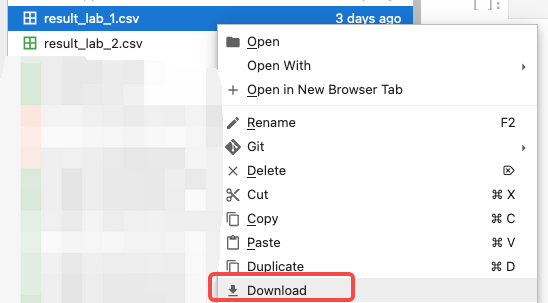